# JSC Assignment 4: The 4-seeable future

### By: el científico de datos Samuel V y Karl N


# Introduction

We are engineers at the state electricity provider in Spain. This project will revolve around developing models which are able to accurately predict future electricity loads based on historical load figures.

## Value Added

An accurate prediction of future loads is extremely valuable for planning electricity production. This means that we are able to more effectively allocate the resources necessary for production, as electricity production is not something that can quickly be toggled on or off. Furthermore, as the involved machinery requires downtime for maintenance and repairs, we can better plan how maintenance is performed relative to predicted demand.

Producing electricity itself requires electricity, so it is most efficient to schedule production for when demand, and hence the price of electricity, is lower. Likewise, producing excess energy at the wrong time may mean significantly lower income from selling it.

## Success Measures

Ultimately, the purpose of this project is to increase income and decrease cost. Perhaps most significantly, effective models can enable the prevention of failures of the electric grid and the involved machinery - such failures could impact hundreds of thousands if not millions of people, and incur insurmountable costs.

The success of this project can be quantified by considering the profit that the company is making when producing energy in guidance with our models and comparing it to the profit that could have been made if production was constantly done at the most optimal time in relation to income and costs. Likewise, we can measure production loss: the amount of energy (and hence profit) that could have been produced, but wasn't due to causes such as machinery being unavailable because of maintenance or failures. The number of outages per some time period could be considered too, but this may not be a very useful indicator as outages are generally rare events anyway. The reliability of the electric grid could be evaluated by looking at the number of customer complaints per time period.

To evaluate our models, we will primarily rely on mean squared error, and visual analysis of results by plotting the predicted vs. true values, which can be very insightful when domain experts are involved in the analysis. 

Since production is based on the predicted load, we may want to consider punishing models which predict under the true value more than those which predict over it: predicting below the true value likely causes underproduction, which may not meet the demand. We could do this by considering a cost function such as the following one:

$$\frac{w_1}{M} \sum^{M}_{y_i - \hat{y}_i \geq 0} (y_i - \hat{y}_i) + \frac{w_2}{K} \sum^{K}_{\hat{y}_i - y_i > 0} (\hat{y}_i - y_i)$$ with $M + K = N$, the number of data points.

Determining the weights $w_1, w_2$ would require some sort of cost-benefit analysis from domain experts.

# Imports

In [ ]:
import pandas as pd
import numpy as np
import datetime
from jax.api import vmap
import jax.numpy as jnp
import numpy.random as npr
from jax.api import jit, grad
from jax.tree_util import tree_multimap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
plt.rcParams["figure.figsize"] = (13, 7)

Data Source: https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather

In [ ]:
!wget https://raw.githubusercontent.com/JSC370/jsc370.github.io/master/energy_dataset.csv
!wget https://raw.githubusercontent.com/JSC370/jsc370.github.io/master/weather_features.csv

--2021-03-23 02:32:56--  https://raw.githubusercontent.com/JSC370/jsc370.github.io/master/energy_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6273009 (6.0M) [text/plain]
Saving to: ‘energy_dataset.csv’

energy_dataset.csv  100%[===================>]   5.98M  39.8MB/s    in 0.2s    

2021-03-23 02:32:56 (39.8 MB/s) - ‘energy_dataset.csv’ saved [6273009/6273009]

--2021-03-23 02:32:56--  https://raw.githubusercontent.com/JSC370/jsc370.github.io/master/weather_features.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

# Data Reading and Cleaning

In [ ]:
energy = pd.read_csv("energy_dataset.csv")
weather = pd.read_csv("weather_features.csv")

df_e = pd.DataFrame(energy)
df_w = pd.DataFrame(weather)

print("shape of energy data:", df_e.shape)
print("shape of weather data:", df_w.shape)

shape of energy data: (35064, 29)
shape of weather data: (178396, 17)


In [ ]:
df_e.head()

time  generation biomass  ...  price day ahead  price actual
0  2015-01-01 00:00:00+01:00               447.0  ...            50.10         65.41
1  2015-01-01 01:00:00+01:00               449.0  ...            48.10         64.92
2  2015-01-01 02:00:00+01:00               448.0  ...            47.33         64.48
3  2015-01-01 03:00:00+01:00               438.0  ...            42.27         59.32
4  2015-01-01 04:00:00+01:00               428.0  ...            38.41         56.04

[5 rows x 29 columns]

In [ ]:
df_w.head()

dt_iso city_name  ...  weather_description  weather_icon
0  2015-01-01 00:00:00+01:00  Valencia  ...         sky is clear           01n
1  2015-01-01 01:00:00+01:00  Valencia  ...         sky is clear           01n
2  2015-01-01 02:00:00+01:00  Valencia  ...         sky is clear           01n
3  2015-01-01 03:00:00+01:00  Valencia  ...         sky is clear           01n
4  2015-01-01 04:00:00+01:00  Valencia  ...         sky is clear           01n

[5 rows x 17 columns]

In [ ]:
print(type(df_e.time[0]))
print(type(df_w.dt_iso[0]))

<class 'str'>
<class 'str'>


In [ ]:
# df_w['time'] = df_w['dt_iso']
# df = df_e.merge(df_w, how='left', on='time')
# df

In [ ]:
############################################ Energy dataset ##########################################
# convert datetime string into timestamp 
# df_e['time'] = df_e['time'].apply(lambda x : pd.to_datetime(str(x)))
df_e["time"] = pd.to_datetime(df_e["time"])

# extracting date from timestamp
df_e['date'] = [datetime.datetime.date(d) for d in df_e['time']] 

# extracting time from timestamp
df_e['time'] = [datetime.datetime.time(d) for d in df_e['time']] 


# changing order of columns for energy dataset
col_e = df_e.columns.tolist()
col_e = col_e[-1:] + col_e[:-1]
df_e = df_e[col_e]

In [ ]:
############################################ Weather dataset ##########################################
# convert datetime string into timestamp 
# df_w['dt_iso'] = df_w['dt_iso'].apply(lambda x : pd.to_datetime(str(x)))
df_w["dt_iso"] = pd.to_datetime(df_w["dt_iso"])

# extracting date from timestamp
df_w['date'] = [datetime.datetime.date(d) for d in df_w['dt_iso']] 


# extracting time from timestamp
df_w['time'] = [datetime.datetime.time(d) for d in df_w['dt_iso']]

df_w = df_w.drop("dt_iso", axis=1) # dropping timestamp column

# changing order of columns for weather dataset
col_w = df_w.columns.tolist()
col_w = col_w[-2:] + col_w[:-2]
df_w = df_w[col_w]

In [ ]:
df_e.head(2)

date      time  ...  price day ahead  price actual
0  2015-01-01  00:00:00  ...             50.1         65.41
1  2015-01-01  01:00:00  ...             48.1         64.92

[2 rows x 30 columns]

In [ ]:
df_w.head(2)

date      time city_name  ...  weather_main  weather_description  weather_icon
0  2015-01-01  00:00:00  Valencia  ...         clear         sky is clear           01n
1  2015-01-01  01:00:00  Valencia  ...         clear         sky is clear           01n

[2 rows x 18 columns]

In [ ]:
# total NaN values in the data
df_e.isnull().sum()

date                                               0
time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                    

In [ ]:
# dropping columns with NaN and zero values
df_e = df_e.drop(["generation hydro pumped storage aggregated",
                  "forecast wind offshore eday ahead",
                  "generation fossil coal-derived gas",
                  "generation fossil oil shale",
                  "generation fossil peat",
                  "generation geothermal",
                  "generation marine",
                  "generation wind offshore"], axis=1)

# drop columns based on forecasts and prices
df_e = df_e.drop(["price actual",
                  "price day ahead",
                  "total load forecast",
                  "forecast wind onshore day ahead",
                  "forecast solar day ahead"], axis=1)

# dropping rows with NaN values.
# Note: It would be better to do this after making the Toeplitz matrix.
df_e = df_e.dropna(axis = 0)


In [ ]:
df_w_all = df_w.groupby(["date", "time"]).mean().reset_index()
df_combined = pd.merge(df_w_all, df_e, on=["date", "time"])

In [ ]:
# Allow an autoregressive model by turning the actual load series into Toeplitz
# matrix, by including copies of the last 48 hours of actual load.

history_interval_length = 48
predict_interval_length = 24
history_long = 24*7
trim = history_interval_length + predict_interval_length
trim_long = history_long + predict_interval_length

# For now, we'll just use load
load = df_e["total load actual"]

indexes = np.stack([np.arange(i, trim+i) for i in range(load.shape[0] - trim + 1)])
indexes_long = np.stack([np.arange(i, trim_long+i) for i in range(load.shape[0] - trim_long + 1)])

tdata = np.stack([load.iloc[indexes[i]] for i in range(indexes.shape[0])])
tdata_long = np.stack([load.iloc[indexes_long[i]] for i in range(indexes_long.shape[0])])

tdata_train = tdata[:30000, :]
tdata_test = tdata[30000:, :]

tdata_train_long = tdata_long[:20000, :]
# tdata_test_long = tdata_long[20000:, :]

# X = tdata[:, :history_interval_length]
# y = tdata[:, history_interval_length:]

In [ ]:
X_train = tdata_train[:, :history_interval_length]
y_train = tdata_train[:, history_interval_length:]
X_test = tdata_test[:, :history_interval_length]
y_test = tdata_test[:, history_interval_length:]

mean_ = X_train.mean()
std_ = X_train.std()
test_mean = X_test.mean()
test_std = X_test.std()

X_train_scaled = (X_train - mean_) / std_
y_train_scaled = (y_train - mean_) / std_
X_test_scaled = (X_test - test_mean) / test_std
y_test_scaled = (y_test - test_mean)/ test_std

# ==== Long: One week history ====

X_train_long = tdata_train_long[:, :history_long]
y_train_long = tdata_train_long[:, history_long:]
# X_test_long = tdata_test_long[:, :history_long]
# y_test_long = tdata_test_long[:, history_long:]

# mean_long = X_train_long.mean()
# std_long = X_train_long.std()
# test_mean_long = X_test_long.mean()
# test_std_long = X_test_long.std()

# X_train_long = (X_train_long - mean_long) / std_long
# y_train_long = (y_train_long - mean_long) / std_long
# X_test_long = (X_test_long - test_mean_long) / test_std_long
# y_test_long = (y_test_long - test_mean_long)/ test_std_long



# Exploratory Data Analysis

In [ ]:
df_e["total load actual"].hist(bins=100)
plt.grid(False)
plt.title("Distribution of total load", fontsize=15)
plt.xlabel("Load (MW)")
plt.show()

The above histogram displays clear bimodality: it is likely that the smaller mode corresponds to night time loads and the greater mode corresponds to daytime loads.

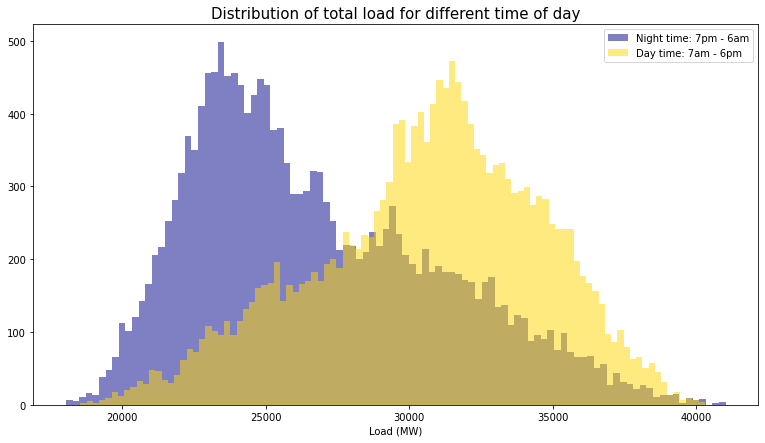

In [ ]:

night = (df_e["time"].apply(lambda x: 0 <= x.hour <= 6)) | \
        (df_e["time"].apply(lambda x: 19 <= x.hour <= 23))

df_e[night]["total load actual"].hist(bins=100, label="Night time: 7pm - 6am",
                                      alpha=0.5, color="darkblue")
df_e[~night]["total load actual"].hist(bins=100, label="Day time: 7am - 6pm", 
                                       alpha=0.5, color="gold")
plt.grid(False)
plt.legend()
plt.title("Distribution of total load for different time of day", fontsize=15)
plt.xlabel("Load (MW)")
plt.show()

While "night time" and "daytime" are not perfectly defined by specific time values, a rough estimate of these periods on the above histogram clearly demonstrates that the two modes correspond to the two periods of the day.

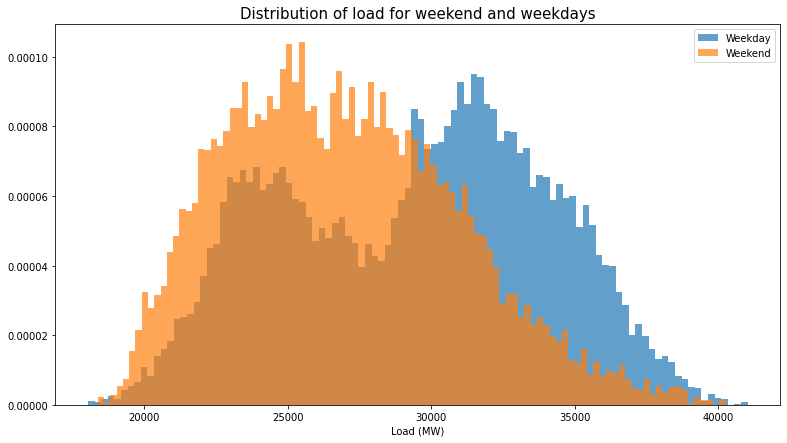

In [ ]:
is_weekday = df_e["date"].apply(lambda x: x.weekday() < 5)
df_e[is_weekday]["total load actual"].hist(bins=100, alpha=0.7, label="Weekday", density=True)
df_e[~is_weekday]["total load actual"].hist(bins=100, alpha=0.7, label="Weekend", density=True)
plt.grid(False)
plt.xlabel("Load (MW)")
plt.legend()
plt.title("Distribution of load for weekend and weekdays", fontsize=15)
plt.show()

Load values during weekends tend to be lower on average, and are distributed unimodally, whereas weekday loads tend to be greater and are distributed bimodally.

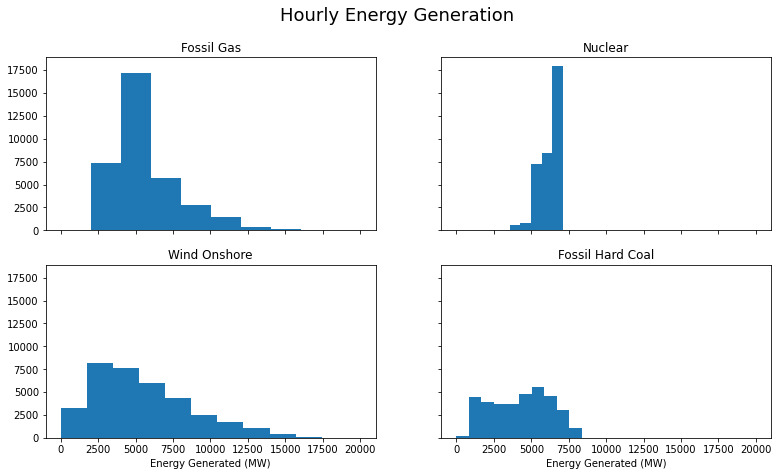

In [ ]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
def plot_generation(data, ax, title):
  ax.hist(data, bins=10)
  ax.title.set_text(title)

plot_generation(df_e["generation fossil gas"], ax[0][0], "Fossil Gas")
plot_generation(df_e["generation nuclear"], ax[0][1], "Nuclear")
plot_generation(df_e["generation wind onshore"], ax[1][0], "Wind Onshore")
plot_generation(df_e["generation fossil hard coal"], ax[1][1], "Fossil Hard Coal")

ax[1][0].set_xlabel("Energy Generated (MW)")
ax[1][1].set_xlabel("Energy Generated (MW)")
fig.suptitle("Hourly Energy Generation", fontsize=18)
plt.show()


The different means of producing energy demonstrate very different behaviours: for example, nuclear energy is very consistent and tends to produce the same amount of energy all the time, but wind energy fluctuates greatly. The total amount of energy produced also varies per resource.

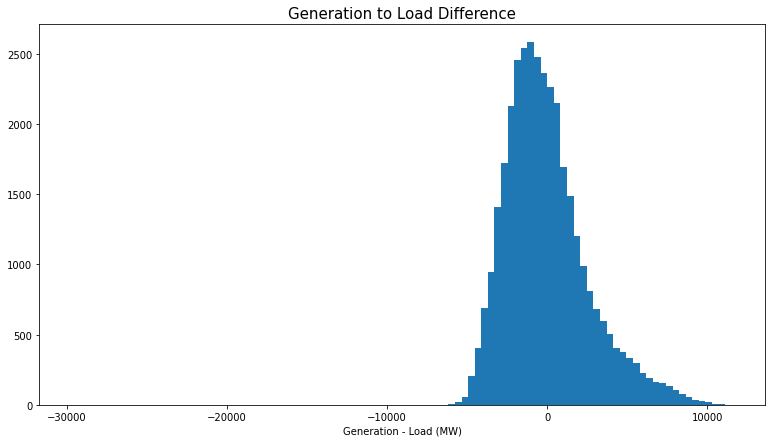

In [ ]:
total_generation = df_e[df_e.columns[2:-1]].sum(axis=1)
generation_difference = (total_generation- df_e["total load actual"])
plt.hist(generation_difference, bins=100)
plt.title("Generation to Load Difference", fontsize=15)
plt.xlabel("Generation - Load (MW)")
plt.show()

The above graph demonstrates that in half of the cases in the dataset more energy was consumed than what was produced: this indicates that energy is not produced to be consumed immediately, and instead it is produced to be stored for later consumption, or sold to other countries and then bought back when the demand in Spain increases. This also means that the decomposed loss function proposed earlier may not be as useful as we first thought.

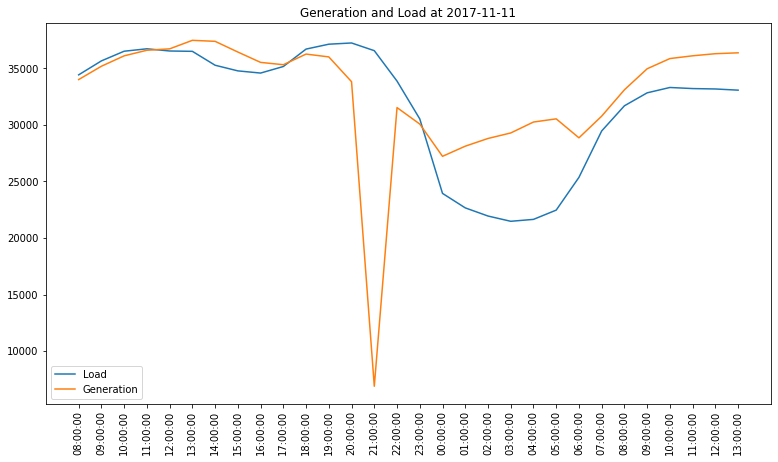

In [ ]:
plt.plot(df_e["total load actual"][25070:25100].values, label="Load")
plt.plot(total_generation[25070:25100].values, label="Generation")
plt.xticks(ticks = np.arange(0, 30), labels=df_e["time"][25070:25100], rotation=90)
plt.title("Generation and Load at 2017-11-11")
plt.legend()
plt.show()

There was one extreme outlier in the previous histogram, pictured here. It appears that this is simply a case of mislabelling rather than a power supply issue: Google leads to no results of power outages in Spain on November 11, 2017.

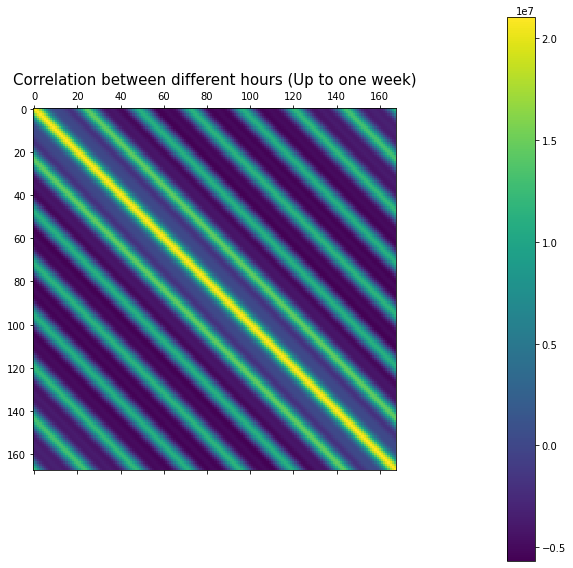

In [ ]:
c = np.cov(X_train_long.T)
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.matshow(c)
plt.title("Correlation between different hours (Up to one week)", fontsize=15)
fig.colorbar(im, pad=0.2)
plt.show()

We note that there is very high correlation with the energy load 24 hours before, and high correlation with every other 24 hour period. The correlation doesn't seem to drop over time (for at least a week).

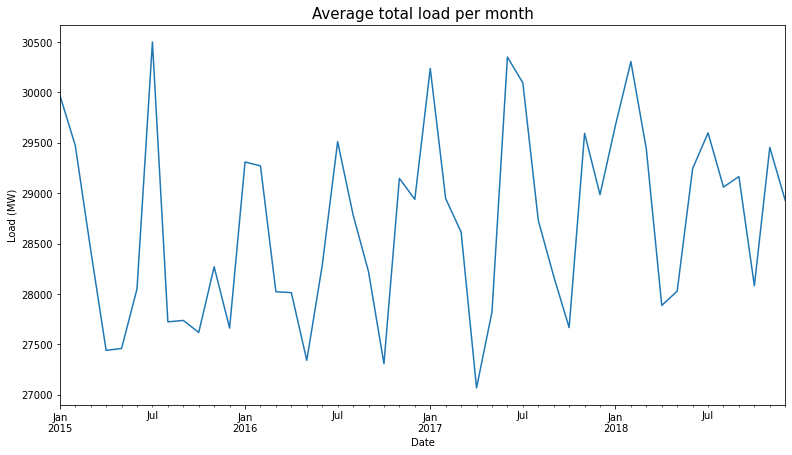

In [ ]:
months = df_e["date"].apply(lambda x: datetime.datetime(year=x.year, month=x.month, day=1))
df_e.groupby(months)["total load actual"].mean().plot()
plt.title("Average total load per month", fontsize=15)
plt.ylabel("Load (MW)")
plt.xlabel("Date")
plt.show()

We see that there seems to be a periodical pattern in the months as well, with January and July consuming the highest electricity. The peaks in January are likely caused by winter. The summer peaks are slightly more mysterious, but are perhaps caused by tourism and air conditioning needed during hot summer days.

In [ ]:
plt.scatter(df_combined["temp"] - 273.15, df_combined["total load actual"], alpha=0.1)
plt.title("Temperature against Total Load", fontsize=15)
plt.xlabel("Temperature (°C)")
plt.ylabel("Load (MW)")
plt.show()

There seems to be a quadratic relationship between temperature and load. Energy usage increases when it gets too cold (approaching 0) or too hot (approaching 35). However, we will avoid using weather data as a feature, as we will explain in the next section.

# Brainstorming

## Complementary Sources of Data

The energy load and production figures themselves definitely do not give us a complete picture of the situation. Our models could benefit from information about when energy demand has been limited: the load figures themselves may be biased as they are dependent by how much can be produced - it may be the case that loads would have been greater if there was enough production capacity.

While we have access to observed weather statistics, we have decided not to use them for our models because in practice we would require forecasts instead of observations when making predictions. Weather forecasts tend to be fairly inaccurate, so obtaining good forecasts would allow us to utilize weather data. Predicting outlying periods with very high demand could be a lot easier if we had information about extraordinary weather conditions such as blizzards or heatwaves.

Likewise, a schedule of holidays, big sports events/concerts/etc., COVID lockdown periods and any other reasons for why people would significantly change their energy consumption behaviour would benefit our models.

Energy demand and supply likely differs regionally across Spain, so obtaining separate figures per region could perhaps be leveraged for better model performance.

## Comprehensive Factors

As mentioned, it is possible that the load figures do not indicate true demand if load has been limited. Load limiting can be affected by production capacity - the availability of resources.

An interesting phenomenon which has been observed is called [TV pickup](https://en.wikipedia.org/wiki/TV_pickup) - a phenomenon of how energy consumption skyrockets when popular TV shows end or go on commercial breaks because masses of people turn on their kettles, use their toilets, etc. at the same time. This speaks to how surges in load figures can be very difficult to predict as very simple yet hard to capture factors can cause them.

People's energy consumption is likely to change in the long run too: an increased dependency on technology will probably increase consumption, but advancements in environment-friendly technology and increases in people's awareness of environmental impact of consumption likely decreases consumption.


# Model Staircase

We have decided on the following model staircase: 

* Model 0: Predict the last 24 hours for the next 24 hours
* Model 1: Linear Regression 
* Model 2: Feed-Forward Neural Network 
* Model 3: Gaussian Process
* Model 5: Seq2Seq RNN
* Model 6: Transformer



In [ ]:
# Model Utils


def plot_predictions(true, pred, time, model_name, is_scaled=False, 
                     std=test_std, mean=test_mean):

  if not is_scaled: 
    pred = (pred * std) + mean

  rmse = np.sqrt((np.sum((true[:, time] - pred[:, time])**2)) / true.shape[0])

  plt.plot(true[:, time], label="True")
  plt.plot(pred[:, time], label="Pred")
  plt.suptitle(f"Predictions {time+1} hour(s) in the future ({model_name})", fontsize=15)
  plt.title('Root mean squared error: {}'.format(round(rmse, 3)))
  plt.legend()
  plt.xlabel("idx")
  plt.ylabel("Load (MW)")

## Model 0: Look back 24 hours

This serves as our baseline model. We simply predict the values from 24 hours ago.

In [ ]:
def lookback_pred(X):
  return X[:, -24:]

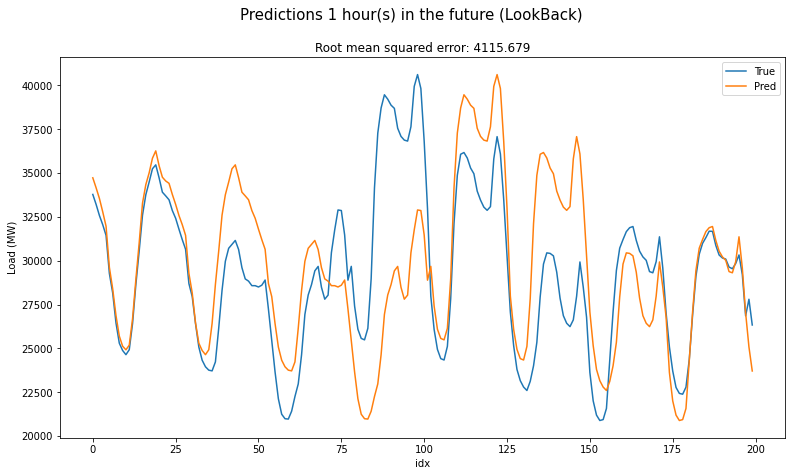

In [ ]:
true = y_test[500:700, :]
look_pred = lookback_pred(X_test_scaled)
plot_predictions(true, look_pred[500:700], 0, "LookBack")

## Model 1: Linear Regression

This model takes the last 48 hours as the input, and predicts the next 24 hours as the output from a linear combination of the inputs.

In [ ]:
alpha = 1e-2 # The learning rate
epochs = 750 # The number of iterations to perform gradient descent

# weights and bias 
params = {
    'm': jnp.zeros([X_train.shape[1], y_train.shape[1]]),
    'c': jnp.zeros(y_train.shape[1])
}

# linear regression 
def linear_reg(params, X):
    return jnp.dot(X, params['m']) + params['c']

# loss function (MSE error)
def loss(params, X, y):
    error = linear_reg(params, X) - y
    return jnp.mean(jnp.square(error))

#update parameters with gradient descent 
def update(params, X, y):
  grads = grad(loss)(params, X, y)
  return tree_multimap(lambda p, g: p - alpha * g, params, grads)

train_loss = [] # loss history

# main training loop
for i in tqdm(range(epochs)):
    params = update(params, X_train_scaled, y_train_scaled)
    train_error = loss(params, X_train_scaled, y_train_scaled)
    train_loss.append(train_error)
    test_error = loss(params, X_test_scaled, y_test_scaled)
    # if i % 50 == 0:
    #   print(i,jnp.mean(train_error), jnp.mean(test_error))

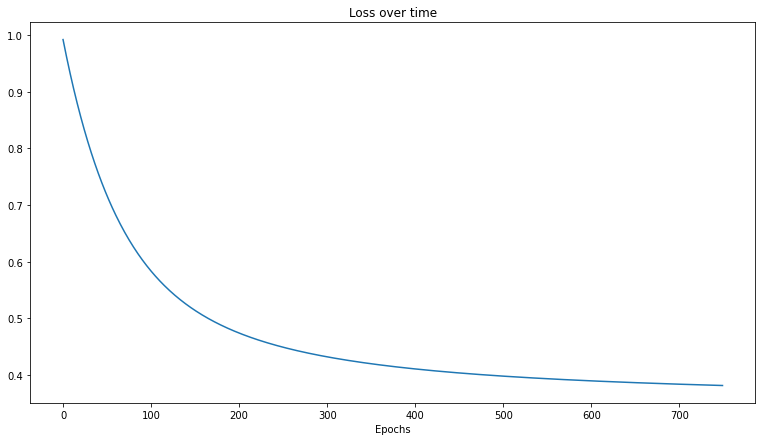

In [ ]:
iterations = range(epochs)
plt.plot(iterations, train_loss)
plt.title("Loss over time")
plt.xlabel("Epochs")
plt.show()

In [ ]:
print(f"Loss after {epochs} epochs: {train_loss[-1]}")

Loss after 750 epochs: 0.3817045986652374


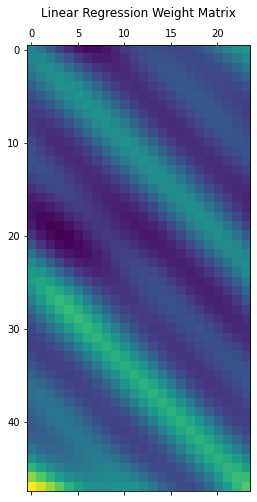

In [ ]:
#params['m'].shape
plt.matshow(params['m'])
plt.title('Linear Regression Weight Matrix')
plt.show()

Plotting the weight matrix shows that the model has captured the periodical correlation over 24-hour periods.

In [ ]:
true = y_test[500:700, :]
lin_pred = linear_reg(params, X_test_scaled)
plot_predictions(true, lin_pred[500:700], 0, "LR")

In [ ]:
plot_predictions(true, lin_pred[500:700], 7, "LR")

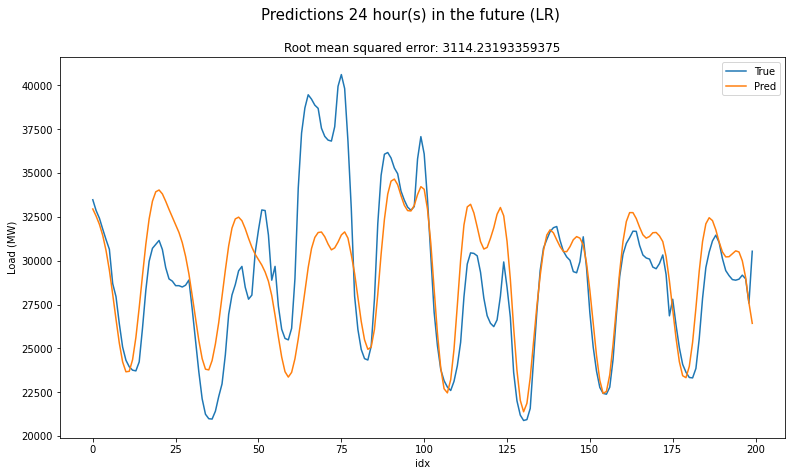

In [ ]:
plot_predictions(true, lin_pred[500:700], 23, "LR")

The linear model works surprisingly well. The model captures the periodicity.

The model does not seem to capture large spikes in load increase very well. Of course, model performance decreases as we increase the length of the prediction period.

## Model 2: Feed Forward Neural Network

We extend the simple LR by replacing it with a simple feed forward neural network. We have 1 hidden layer with 200 neurons, and a Tanh activation. 

In [ ]:
alpha = 1e-1 # The learning rate
epochs = 500 # The number of iterations to perform gradient descent
hidden = 200

def tanh_activation(x):
  return jnp.tanh(x)
  

# weights and bias 
net_params = {
    "W1": np.random.normal(size=(X_train.shape[1], hidden)) * 0.01,
    "W1b": np.random.normal(size=(hidden)) * 0.01,
    "W2": np.random.normal(size=(hidden, y_train.shape[1])) * 0.01,
    "W2b": np.random.normal(size=(y_train.shape[1])) * 0.01
}

# linear regression 
def net(params, X):

    H1 = (X @ params["W1"]) + params["W1b"]
    H1 = tanh_activation(H1)
    out = (H1 @ params["W2"]) + params["W2b"]

    return out

# loss function (MSE error)
def loss(params, X, y):
    error = net(params, X) - y
    return jnp.mean(jnp.square(error))

#update parameters with gradient descent 
def update(params, X, y):
  grads = grad(loss)(params, X, y)
  return tree_multimap(lambda p, g: p - alpha * g, params, grads)

train_loss = [] # loss history

# main training loop
for i in tqdm(range(epochs)):
    net_params = update(net_params, X_train_scaled, y_train_scaled)
    train_error = loss(net_params, X_train_scaled, y_train_scaled)
    train_loss.append(train_error)
    test_error = loss(net_params, X_test_scaled, y_test_scaled)
    # if i % 50 == 0:
    #   print(i,jnp.mean(train_error), jnp.mean(test_error))

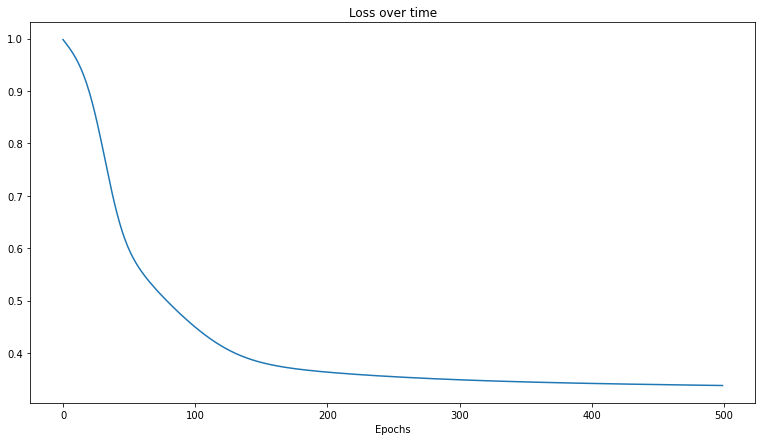

In [ ]:
iterations = range(epochs)
plt.plot(iterations, train_loss)
plt.title("Loss over time")
plt.xlabel("Epochs")
plt.show()

In [ ]:
print(f"Loss after {epochs} epochs: {train_loss[-1]}")

Loss after 500 epochs: 0.33794304728507996


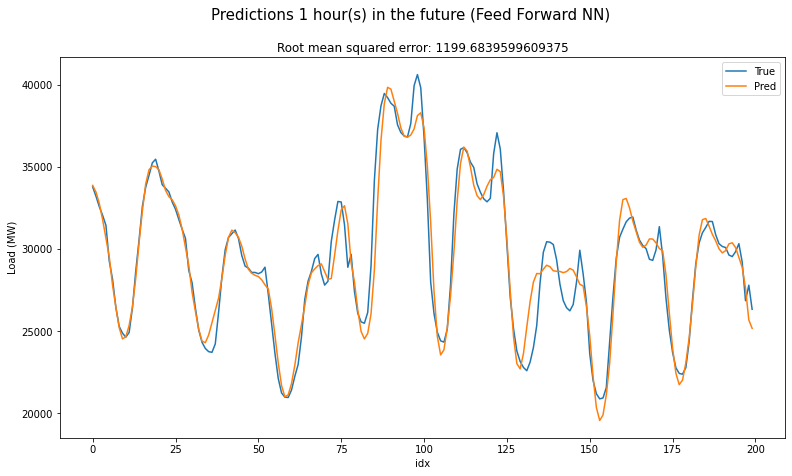

In [ ]:
true = y_test[500:700]
nn_pred = net(net_params, X_test_scaled)
plot_predictions(true, nn_pred[500:700], 0, "Feed Forward NN")

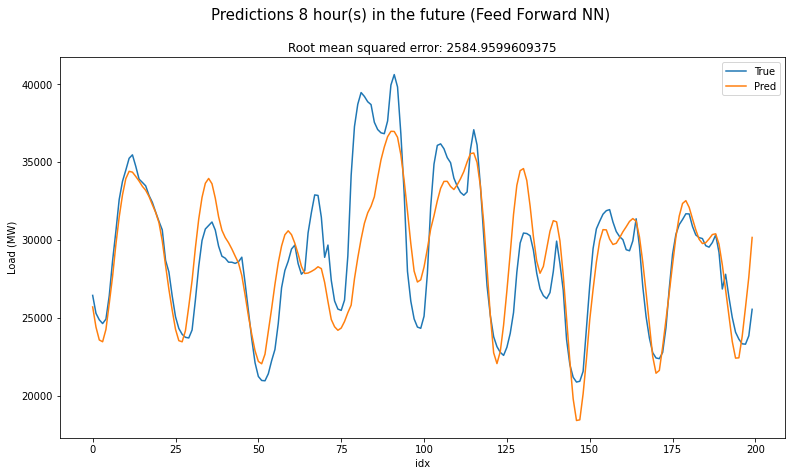

In [ ]:
plot_predictions(true, nn_pred[500:700], 7, "Feed Forward NN")

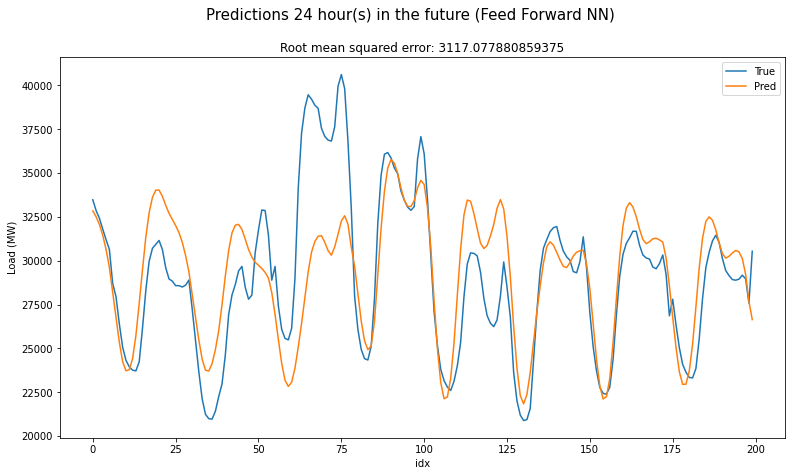

In [ ]:
plot_predictions(true, nn_pred[500:700], 23, "Feed Forward NN")

The neural net shows a noticeable improvement in performance for predictions 1 hour into the future, but not as much for longer periods. Still, the results are encouraging as the NN does a better job at predicting the high load peak in the test dataset.


## Model 3: Gaussian Process

Since Gaussian Proccesses run in $\mathcal{O}(n^3)$ time, we can only feed in about 1000 datapoints into the model. Therefore, we don't know how well it will work compared to the previous 2 models. 

Moreover, it is difficult to attain the most optimal kernel. This may create some difficulty in creating a model that fits the data well. 

However, an advantage of using this model is that we can create interval predictions. This may be more helpful to the electrical engineers compared to other models, even if they are more accurate.

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, Matern, RBF, DotProduct

X_train_small = X_train_scaled[:1000, :]
y_train_small = y_train_scaled[:1000, :]

kernels = [Matern(), RBF(), DotProduct()]
gps = []

for kernel in kernels: 
  gp = GaussianProcessRegressor(kernel=kernel, random_state=0)
  gp.fit(X_train_small, y_train_small)
  gps.append(gp)

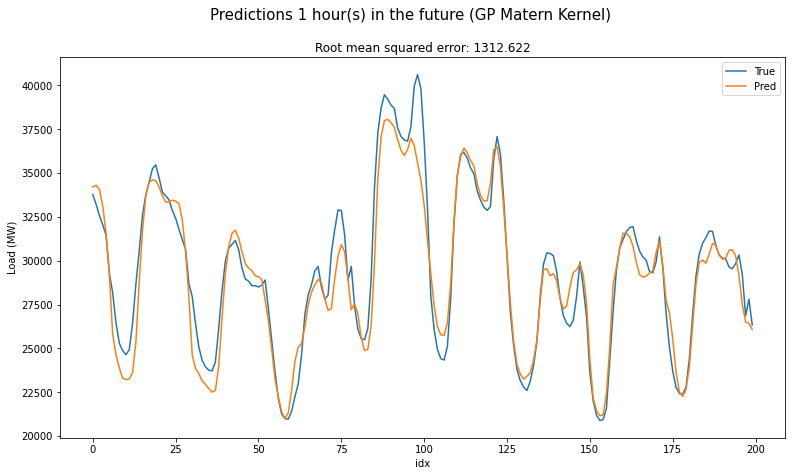

In [ ]:
true = y_test[500:700]
gp_preds = [gp.predict(X_test_scaled) for gp in gps]
plot_predictions(true, gp_preds[0][500:700], 0, "GP Matern Kernel")

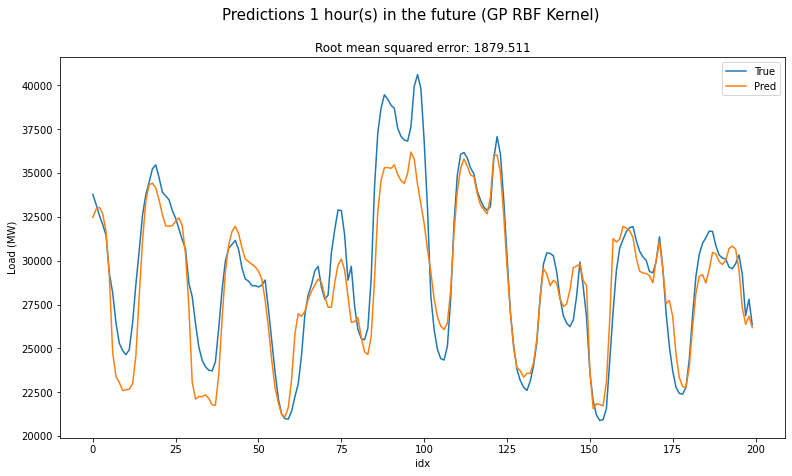

In [ ]:
plot_predictions(true, gp_preds[1][500:700], 0, "GP RBF Kernel")

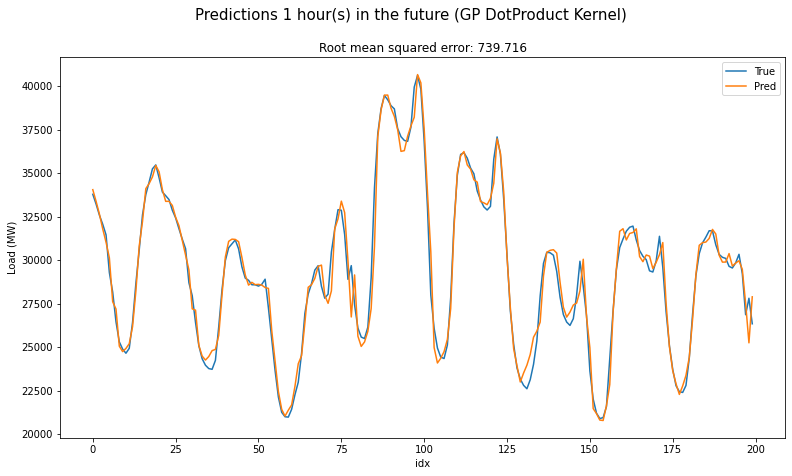

In [ ]:
plot_predictions(true, gp_preds[2][500:700], 0, "GP DotProduct Kernel")

The dot product kernel seemed to work best. We have to be mindful that there are plenty of combinations that we did not try, and so this might not be the optimal kernel. 

However, it does fit the data very well considering that we are only using 1/30th the data for the other models.

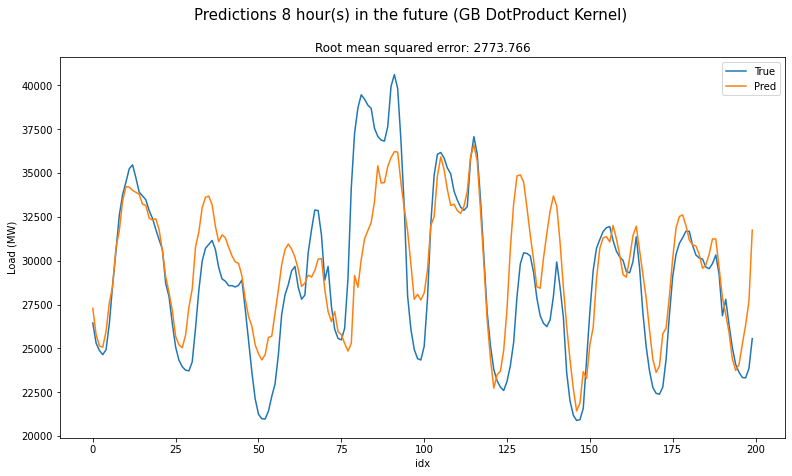

In [ ]:
plot_predictions(true, gp_preds[2][500:700], 7, "GB DotProduct Kernel")

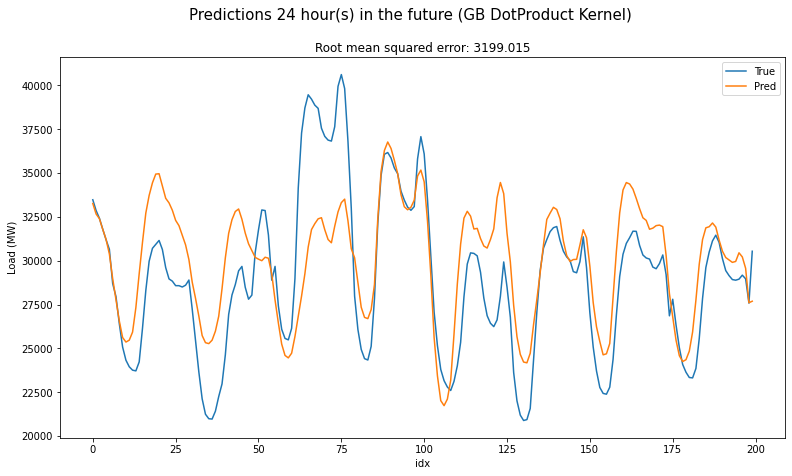

In [ ]:
plot_predictions(true, gp_preds[2][500:700], 23, "GB DotProduct Kernel")

We see that the quality of the predictions fall more quickly compared to the Feed Forward NN. It did not detect the spike for predictions 8 hours in the future. We also note that the predictions look less smooth compared to the other models.

## Model 4: Recurrent Neural Network with Gated Recurrent Units


A Seq2Seq model inspired by this [article](https://towardsdatascience.com/encoder-decoder-model-for-multistep-time-series-forecasting-using-pytorch-5d54c6af6e60). 

The model architecture: 

![](https://raw.githubusercontent.com/Arturus/kaggle-web-traffic/master/images/encoder-decoder.png)

[Image credit](https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/43795)

One advantage of this model is that we can easily extend the length of the predicted sequence. 

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

BATCH_SIZE = 64
EPOCHS = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
class EnergyDataset(Dataset): 
  def __init__(self, X, y, scaled=True, mean=None, std=None):

    self.X = X
    self.y = y 

    self.mean_ = X.mean() if scaled else 0
    self.std_ = X.std() if scaled else 1

    if mean is None:
      self.X = (self.X - self.mean_) / self.std_ 
      self.y = (self.y - self.mean_) / self.std_ 
    else:
      self.X = (self.X - mean)/std
      self.y = (self.y - mean)/std

  def __getitem__(self, idx):
    return self.X[idx, :], self.y[idx, :]

  def unscale(self, X):
    return (X * self.std_) + self.mean_

  def get_stats(self):
    return self.mean_, self.std_

  def __len__(self):
    return self.X.shape[0]

# mean_ = X_train[:9].mean()
# std_ = X_train[:9].std()

# X_san = (X_train[:9] - mean_) / std_
# y_san = (y_train[:9] - mean_) / std_ 


sanity_dataset = EnergyDataset(X_train[:200], y_train[:200])
train_dataset = EnergyDataset(X_train, y_train)
test_dataset = EnergyDataset(X_test, y_test)
# train_long_dataset = EnergyDataset(X_train_long, y_train_long)
# test_long_dataset = EnergyDataset(X_test_long, y_test_long)

sanity_dataloader = DataLoader(sanity_dataset, batch_size=len(sanity_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset)
# train_long_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE)

In [ ]:
class EnergyEncoder(nn.Module):

  def __init__(self, hidden_size):
    super().__init__()
    self.gru = nn.GRU(input_size=1, hidden_size=hidden_size,
                      batch_first= True)
    
  def forward(self, x):

    out, hidden = self.gru(x)
    return out, hidden.squeeze(0)


class EnergyDecoder(nn.Module):

  def __init__(self, hidden_size):
    super().__init__()
    self.grucell = nn.GRUCell(input_size=1, hidden_size=hidden_size)

    self.fc = nn.Sequential(
        nn.Linear(in_features=hidden_size, out_features=hidden_size),
        nn.LeakyReLU(),
        nn.Linear(in_features=hidden_size, out_features=1)
    )
    # self.fc = nn.Linear(in_features=hidden_size, out_features=1)

  def forward(self, y, hidden):

    ht = self.grucell(y, hidden)
    out = self.fc(ht)
    return out, ht


class EnergyEncoderDecoder(nn.Module):

  def __init__(self, hidden_size, output_size):
    super().__init__()
    self.encoder = EnergyEncoder(hidden_size)
    self.decoder = EnergyDecoder(hidden_size)
    self.output_size = output_size

  def forward(self, x):

    encoder_out, hidden = self.encoder(x) # [batchsize, hidden_size]
    N = x.shape[0]
    outputs = torch.empty(N, self.output_size)
    curr = x[:, -1]
    for i in range(self.output_size):
      curr, hidden = self.decoder(curr, hidden)
      outputs[:, i] = curr.view(-1)

    return outputs

In [ ]:
model = EnergyEncoderDecoder(150, predict_interval_length)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
model = model.to(device)

In [ ]:
losses = []
for epoch in range(EPOCHS):
  t = tqdm(train_dataloader, desc=f"Epoch: {epoch}")
  # t = train_dataloader
  # t = sanity_dataloader
  cost = 0
  for i, (prev, target) in enumerate(t):
    pred = model(prev.unsqueeze(-1).float().to(device))
    loss = criterion(pred, target.float())
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    cost += float(loss.item() * prev.shape[0])
    
  losses.append(cost/len(train_dataset))

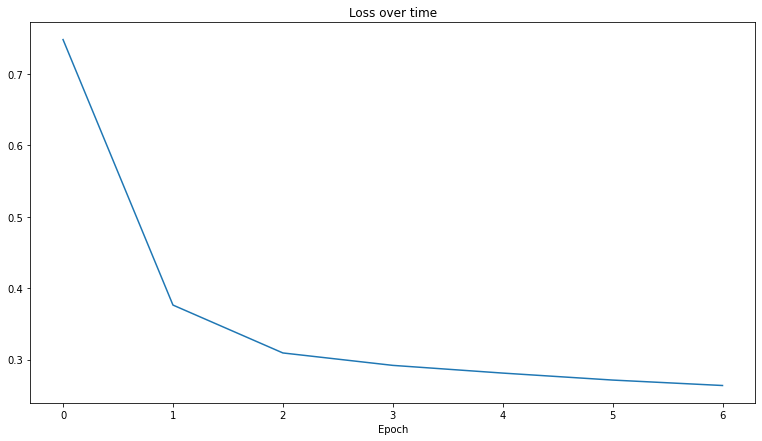

In [ ]:
plt.plot(losses)
plt.title("Loss over time")
plt.xlabel("Epoch")
plt.show()

In [ ]:
torch.cuda.empty_cache()
X_test_tensor = torch.FloatTensor(test_dataset.X).unsqueeze(-1).to(device)
with torch.no_grad():
  rnn_pred = model(X_test_tensor)
rnn_pred = rnn_pred.detach().cpu().numpy()

[]

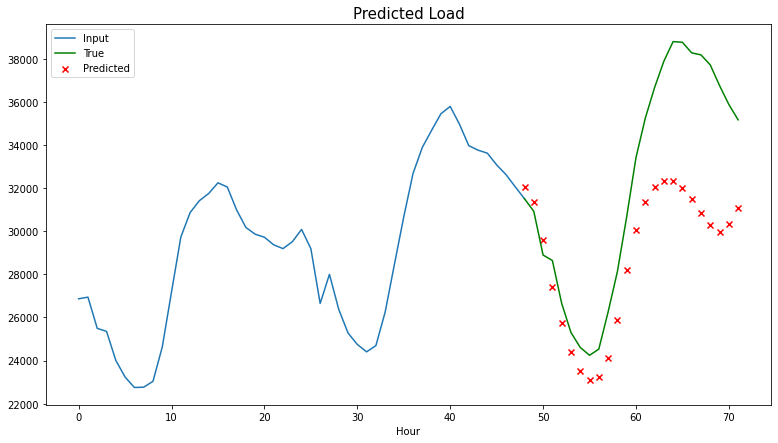

In [ ]:
plt.plot(np.arange(49), np.r_[test_dataset.unscale(test_dataset.X[0, :]), test_dataset.unscale(test_dataset.y[0, 0])], label="Input")
plt.plot(np.arange(48, 72), test_dataset.unscale(test_dataset.y[0, :]), label="True", c="green")
plt.scatter(np.arange(48, 72), test_dataset.unscale(rnn_pred[0, :]), label="Predicted", marker="x", c="red")
plt.title("Predicted Load", fontsize=15)
plt.xlabel("Hour")
plt.legend()
plt.plot()


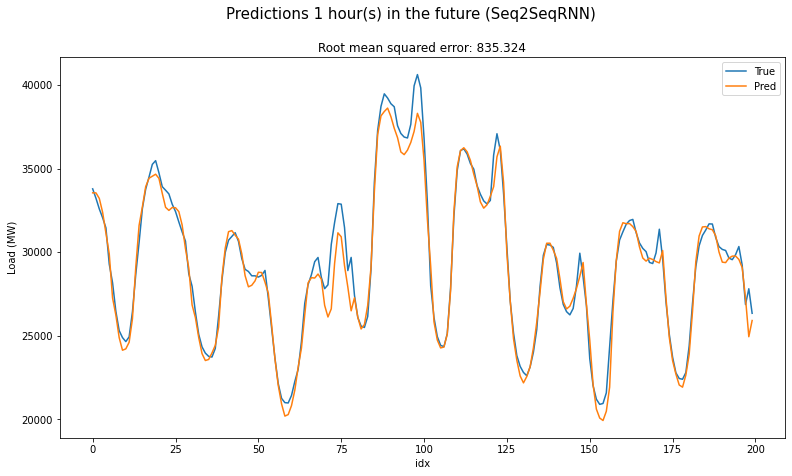

In [ ]:
true = y_test[500: 700]

plot_predictions(true, rnn_pred[500:700], 0, "Seq2SeqRNN")

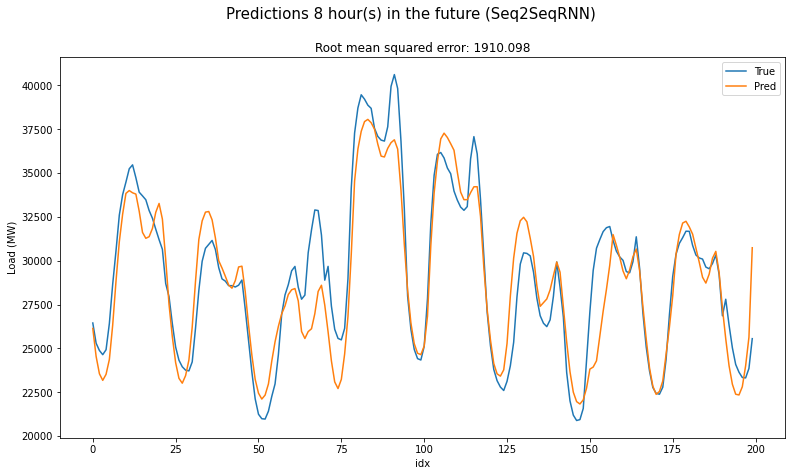

In [ ]:
plot_predictions(true, rnn_pred[500:700], 7, "Seq2SeqRNN")

In [ ]:
plot_predictions(true, rnn_pred[500:700], 23, "Seq2SeqRNN")

The RNN model performs well on predictions 1 hour in the future like the other models. For the predictions 24 hours in the future, it failed to detect the major spike as with the other models.

However, this model can accurately detect the spike very well with predictions 8 hours in the future.

In [ ]:
encoder_out, encoder_hidden = model.encoder(X_test_tensor)
encoder_hidden = encoder_hidden.detach().cpu().numpy()
peek_into = encoder_hidden[500:800]

In [ ]:
plt.imshow(peek_into.T)
plt.title("Context vectors")
plt.xlabel("idx")
plt.ylabel("Context Vector")
plt.show()

There seems to be some sort of periodicity with the context vectors.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=3, random_state=370)
clusters = clusterer.fit_predict(encoder_hidden)
silhouette_score(encoder_hidden, clusters)

0.3671318

Text(0.5, 1.0, 'Loads from cluster 0')

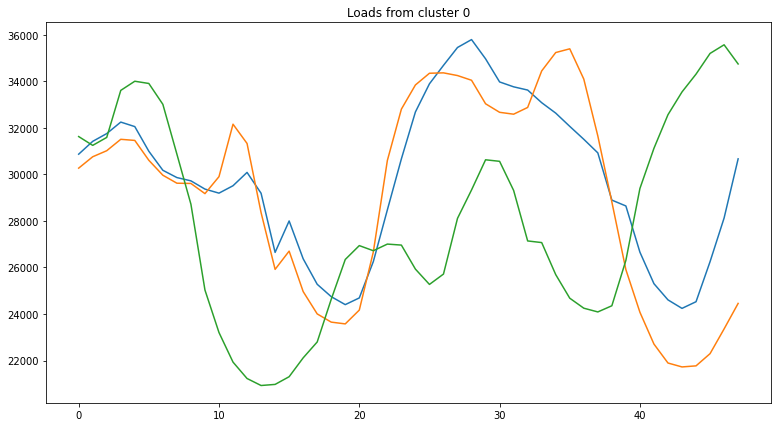

In [ ]:
cluster_0 = X_test[clusters == 0, :]
for i in [0, 521, 783]:
  plt.plot(cluster_0[i, :])

plt.title("Loads from cluster 0")

In [ ]:
cluster_1 = X_test[clusters == 1, :]
for i in [13, 201, 520]:
  plt.plot(cluster_1[i, :])

plt.title("Loads from cluster 1")
plt.show()

In [ ]:
cluster_2 = X_test[clusters == 2, :]
for i in [43, 294, 951]:
  plt.plot(cluster_2[i, :])

We clustered the context vectors into 3 groups (Chosen by maximizing silhouette score). They seem to capture different phases. 


It is difficult to fully understand the context vectors of the RNN; this is a major flow of this Seq2Seq model. We can improve this by extending it to have attention.

### Model 4B: RNN with longer history period

We want to test the memory capabilities of the RNN by including the preceding 168 hours (a week) as the input. (Spoiler alert: it didn't work as well as we thought, and took up a lot of RAM) 

In [ ]:
# model_long = EnergyEncoderDecoder(200, predict_interval_length)
# optimizer = optim.AdamW(model_long.parameters(), lr=1e-3)
# criterion = nn.MSELoss()
# model_long = model_long.to(device)

In [ ]:
# costs = []
# for epoch in range(EPOCHS):
#   t = tqdm(train_long_dataloader, desc=f"Epoch: {epoch}")
#   # t = train_dataloader
#   # t = sanity_dataloader
#   cost = 0
#   for i, (prev, target) in enumerate(t):
#     pred = model_long(prev.unsqueeze(-1).float().to(device))
#     loss = criterion(pred, target.float())
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()
#     cost += float(loss.item() * prev.shape[0])
    
#   costs.append(cost)

In [ ]:
# plt.plot(costs)
# plt.title("Cost over time")
# plt.xlabel("Epoch")
# plt.show()

In [ ]:
# torch.cuda.empty_cache()
# X_test_tensor = torch.FloatTensor(test_long_dataset.X[:1000]).unsqueeze(-1).to(device)
# with torch.no_grad():
#   rnn_long_pred = model_long(X_test_tensor)
# rnn_long_pred = rnn_long_pred.detach().cpu().numpy()

In [ ]:
# true = y_test_long[400:600]
# plot_predictions(true, rnn_long_pred[400:600], 0, "Seq2SeqRNN", std=test_std_long, mean=test_mean_long)
# # plot_predictions(true, rnn_long_pred[400:600], 0, "Seq2SeqRNN")

In [ ]:
# plot_predictions(true, rnn_long_pred[400:600], 7, "Seq2SeqRNN", std=test_std_long, mean=test_mean_long)

In [ ]:
# plot_predictions(true, rnn_long_pred[400:600], 23, "Seq2SeqRNN", 
#                  std=test_std_long, mean=test_mean_long)

There seems to be minimal improvement. This might be due to two factors: 
* We need to use a larger context vector to properly capture the latent variable
* The model cannot remember sequences that are too long.

Due to the fact that it takes up a lot of GPU RAM, we will not consider this model for our model summary. 

## Model 5: Transformer

This model is the transformer from the famous paper [Attention is all you need (2017)](https://arxiv.org/abs/1706.03762) by Vaswani et al., with slight modifications for it to work on time series. The motivation of using a transformer is its ability to attend to earlier values in the sequence. If our model is successful at its task, visualizing the attention weights may provide interesting insights.

We quickly realised that getting this model to work on time series is not a trivial task, so this model is very experimental and we must be very cautious about interpreting its results.

When writing this model we used the partial transformer implementation from [CSC413's Programming Assignment 3](https://colab.research.google.com/github/csc413-uoft/2021/blob/master/assets/assignments/nmt.ipynb) and the [Pytorch transformer tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) as guidance.

The figure below (obtained from the paper) shows the original transformer model proposed by Vaswani et al.:

![](https://www.researchgate.net/profile/Dennis-Gannon-2/publication/339390384/figure/fig1/AS:860759328321536@1582232424168/The-transformer-model-from-Attention-is-all-you-need-Viswani-et-al.jpg)

We alter the model in the following ways:

- Instead of input embedding, we expand every load value into a vector of size `num_hidden`, the number of hidden units throughout the model, by simply repeating the load value `num_hidden` times. Then, we apply positional encoding as usual. We also note that the positional encoding proposed by the paper may not be fully suitable for time series, but we were unable to figure out a suitable alternative, and the original encoding seems to work well enough.

- We do not use layer normalization. We did not observe any increase in performance while doing so, and hence we removed layer normalization to slightly simplify the model.

- We use a linear layer without an activation function to obtain the final load prediction. Tanh was the only activation function that sort of worked, but it caused all of the predictions to be within an interval centered around the mean, so it never predicted very high or low load values.


In [ ]:
import math
class UnmaskedAttention(nn.Module):
  """
  Scaled dot-product attention.

  Guidance for writing this class is from the CSC413 assignment, as it was one
  of the original tasks.
  """
  def __init__(self, hidden_size):
    super(UnmaskedAttention, self).__init__()
    self.hidden_size = hidden_size
    self.neg_inf = torch.tensor(-1e7)

    self.Q = nn.Linear(hidden_size, hidden_size)
    self.K = nn.Linear(hidden_size, hidden_size)
    self.V = nn.Linear(hidden_size, hidden_size)

    self.softmax = nn.Softmax(dim=1)
    self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float))

    self.drop = nn.Dropout(0.1)

  def forward(self, queries, keys, values):
        batch_size = keys.size(0)
        q = self.Q(queries.view(batch_size, -1, self.hidden_size))
        k = self.K(keys)
        v = self.V(values)
        #print(q.shape, k.shape)
        unnormalized_attention = (torch.bmm(k, q.transpose(2,1))) * self.scaling_factor

        attention_weights = self.softmax(unnormalized_attention)
        assert attention_weights.shape == (batch_size, keys.size(1), q.size(1))
        context = torch.bmm(attention_weights.transpose(2,1), v)
        assert context.shape == (batch_size, q.size(1), self.hidden_size)
        
        return self.drop(context), self.drop(attention_weights)

class MaskedAttention(nn.Module):
  """
  Scaled dot-product attention with future elements of the sequence masked out.

  Guidance for writing this class is from the CSC413 assignment, as it was one
  of the original tasks.
  """
  def __init__(self, hidden_size):
    super(MaskedAttention, self).__init__()
    self.hidden_size = hidden_size
    self.neg_inf = torch.tensor(-1e7)

    self.Q = nn.Linear(hidden_size, hidden_size)
    self.K = nn.Linear(hidden_size, hidden_size)
    self.V = nn.Linear(hidden_size, hidden_size)

    self.softmax = nn.Softmax(dim=1)
    self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float))

    self.drop = nn.Dropout(0.1)

  def forward(self, queries, keys, values):
        batch_size = keys.size(0)
        q = self.Q(queries.view(batch_size, -1, self.hidden_size))
        k = self.K(keys)
        v = self.V(values)
        #print(q.shape, k.shape)
        unnormalized_attention = (torch.bmm(k, q.transpose(2,1))) * self.scaling_factor

        mask = torch.triu(unnormalized_attention) == 0.0
        attention_weights = self.softmax(unnormalized_attention + mask * self.neg_inf)
        assert attention_weights.shape == (batch_size, keys.size(1), q.size(1))
        context = torch.bmm(attention_weights.transpose(2,1), v)
        assert context.shape == (batch_size, q.size(1), self.hidden_size)
        
        return self.drop(context), self.drop(attention_weights)

In [ ]:
class TransformerEncoder(nn.Module):
  """
  input -> vector representation -> add positional encoding -> 
  [multi-head attention -> feed-forward] x num_layers

  Final output is batch size x sequence length x num hidden units.
  """
  def __init__(self, hidden_size, num_layers, seq_len):
    super(TransformerEncoder, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.seq_len = seq_len

    self.activation = nn.ReLU()
  
    # Compute attention
    self.self_attentions = nn.ModuleList([UnmaskedAttention(
                                hidden_size=hidden_size 
                              ) for i in range(num_layers)])
    # Feed-forward
    self.attention_mlps = nn.ModuleList([nn.Sequential(
                                nn.Linear(hidden_size, hidden_size),
                                self.activation,
                              ) for i in range(num_layers)])

    # Positional encoding to add to latent representation
    self.positional_encodings = self.create_positional_encodings()

  def forward(self, inputs):
    # inputs batch x seq_len
    rep = inputs.view(inputs.size(0), inputs.size(1), 1)
    rep = rep.repeat(1, 1, self.hidden_size)
    rep = rep + self.positional_encodings[:self.seq_len]

    for i in range(self.num_layers):
      out, weights = self.self_attentions[i](rep, rep, rep)
      residual = out + rep
      out = self.attention_mlps[i](residual)
      rep = out + residual

    return rep, None, None

  def create_positional_encodings(self, max_seq_len=5000):
      """Creates positional encodings for the inputs.
      This function is taken from the CSC413 assignment starter code.
      """
      pos_indices = torch.arange(max_seq_len)[..., None]
      dim_indices = torch.arange(self.hidden_size//2)[None, ...]
      exponents = (2*dim_indices).float()/(self.hidden_size)
      trig_args = pos_indices / (10000**exponents)
      sin_terms = torch.sin(trig_args)
      cos_terms = torch.cos(trig_args)

      pos_encodings = torch.zeros((max_seq_len, self.hidden_size))
      pos_encodings[:, 0::2] = sin_terms
      pos_encodings[:, 1::2] = cos_terms


      pos_encodings = pos_encodings.cuda()

      return pos_encodings


class TransformerDecoder(nn.Module):
  """
  input -> vector representation -> add positional encoding ->
  [masked multi-head attention -> multi-head attention using encoder output ->
  feed-forward] x num_layers -> feed-forward

  Final output is batch size x sequence length.
  """
  def __init__(self, hidden_size, num_layers, seq_len):
    super(TransformerDecoder, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.seq_len = seq_len

    self.activation = nn.ReLU()
    self.rep_activation = nn.Tanh()
    
    # Masked attention - future elements of sequence masked out
    self.self_masked_attentions = nn.ModuleList([MaskedAttention(
                                hidden_size=hidden_size
                              ) for i in range(num_layers)])
    # Compute attention
    self.self_attentions = nn.ModuleList([UnmaskedAttention(
                                hidden_size=hidden_size
                              ) for i in range(num_layers)])
    # Feed-forward
    self.attention_mlps = nn.ModuleList([nn.Sequential(
                                nn.Linear(hidden_size, hidden_size),
                                self.activation,
                                nn.Dropout(0.1)
                              ) for i in range(num_layers)])

    # Positional encoding to add to latent representation
    self.positional_encodings = self.create_positional_encodings()
    # Output layer
    self.out = nn.Sequential(
        nn.Linear(hidden_size, 1)#, self.rep_activation
    )

  def forward(self, inputs, hiddens):
    rep = inputs.view(inputs.size(0), inputs.size(1), 1)
    rep = rep.repeat(1, 1, self.hidden_size)
    rep = rep + self.positional_encodings[:self.seq_len] # batch x seq_len x hidden
    

    weights_1 = []
    weights_2 = []
    for i in range(self.num_layers):
      out, weights = self.self_masked_attentions[i](rep, rep, rep)
      residual = out + rep
      out, other_weights = self.self_attentions[i](residual, hiddens, hiddens)
      residual = residual + out
      out = self.attention_mlps[i](residual)
      rep = residual + out

      weights_1.append(weights)
      weights_2.append(other_weights)

    weights_1 = torch.stack(weights_1)
    weights_2 = torch.stack(weights_2)
    out = self.out(rep) # batch x seq_len x 1
    return out.view(out.size(0), out.size(1)), weights_1, weights_2

  def create_positional_encodings(self, max_seq_len=5000):
      """Creates positional encodings for the inputs.
      This function is taken from the CSC413 assignment starter code.
      """
      pos_indices = torch.arange(max_seq_len)[..., None]
      dim_indices = torch.arange(self.hidden_size//2)[None, ...]
      exponents = (2*dim_indices).float()/(self.hidden_size)
      trig_args = pos_indices / (10000**exponents)
      sin_terms = torch.sin(trig_args)
      cos_terms = torch.cos(trig_args)

      pos_encodings = torch.zeros((max_seq_len, self.hidden_size))
      pos_encodings[:, 0::2] = sin_terms
      pos_encodings[:, 1::2] = cos_terms

      
      pos_encodings = pos_encodings.cuda()

      return pos_encodings


class Transformer(nn.Module):
  def __init__(self, hidden_size, num_layers, seq_len, output_size):
    super().__init__()
    self.encoder = TransformerEncoder(hidden_size, num_layers, seq_len)
    self.decoder = TransformerDecoder(hidden_size, num_layers, seq_len)
    self.output_size = output_size

  def forward(self, x):

    encoder_out, foo, bar = self.encoder(x)
    N = x.shape[0]
    outputs = torch.empty(N, self.output_size)
    curr = x
    outputs, hidden, foo = self.decoder(curr, encoder_out)

    return outputs, hidden, foo

In [ ]:
indexes = np.stack([np.arange(i, 48*2+i) for i in range(load.shape[0] - (48*2 - 1))])
tdata = np.stack([load.iloc[indexes[i]] for i in range(indexes.shape[0])])

tdata_train = tdata[:30000, :]
tdata_test = tdata[30000:, :]

history_interval_length = 48
X_train_alt = tdata_train[:, :history_interval_length]
y_train_alt = tdata_train[:, history_interval_length:]
X_test_alt = tdata_test[:, :history_interval_length]
y_test_alt = tdata_test[:, history_interval_length:]

The cell below contains all of the relevant hyperparameters. We believe that these are not fully optimal, but provide a satisfactory result. If we had more time and compute, we would love to optimize the model further.

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

BATCH_SIZE = 128
EPOCHS = 100

sanity_dataset = EnergyDataset(X_train_alt[:200], y_train_alt[:200])
train_dataset = EnergyDataset(X_train_alt, y_train_alt)
mean, std = train_dataset.get_stats()
test_dataset = EnergyDataset(X_test_alt, y_test_alt, mean=mean, std=std)

sanity_dataloader = DataLoader(sanity_dataset, batch_size=len(sanity_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset)

torch.cuda.empty_cache()
model = Transformer(32, 3, 48, 48) # hiddens, layers, seq_len, output_len
                                   # Note that seq_len must equal output_len:
                                   # the current code is not designed for
                                   # different input/output seq lengths
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer.zero_grad()
scheduler = MultiStepLR(optimizer, milestones=[90], gamma=0.1)
criterion = nn.MSELoss()
model = model.to(device)

Training on GPU should take max 10 minutes.

In [ ]:
costs = []
hidden_1 = None
hidden_2 = None
try:
  for epoch in range(EPOCHS):
    t = tqdm(train_dataloader, desc=f"Epoch: {epoch}")
    # t = train_dataloader
    # t = sanity_dataloader
    cost = 0
    for i, (prev, target) in enumerate(t):
      optimizer.zero_grad()
      pred, hidden_1, hidden_2 = model(prev.float().to(device))
      loss = criterion(pred.to(device), target.float().to(device))
      
      loss.backward()
      optimizer.step()
      scheduler.step()
      #cost += float(loss.item() * prev.shape[0])
      
    costs.append(loss.item())
    print(loss.item())
except KeyboardInterrupt:
  print("Training stopped manually.")


0.76497483253479



0.6912662982940674



0.6518374085426331



0.6397494077682495



0.6172806620597839



0.598092794418335



0.5808857083320618



0.561100423336029



0.5584909915924072



0.5683236718177795



0.5545305609703064



0.5492538809776306



0.5414307713508606



0.5389329195022583



0.5287312269210815



0.5215048789978027



0.5190097093582153



0.5061087608337402



0.5057159066200256



0.5049678683280945



0.5012980699539185



0.4922415316104889



0.4891388714313507



0.48218652606010437



0.4790036976337433



0.474224716424942



0.4618820548057556



0.46264490485191345



0.4571889340877533



0.46471092104911804



0.4602634012699127



0.4546051025390625



0.4576106667518616



0.46196234226226807



0.4554256796836853



0.4569272994995117



0.45150279998779297



0.4487975537776947



0.45383474230766296



0.44955122470855713



0.4435460865497589



0.4453268051147461



0.45491257309913635



0.4399898648262024



0.43437090516090393



0.4437927305698395



0.4393114447593689



0.438748836517334



0.4392687976360321



0.4365312159061432



0.4391031861305237



0.44098588824272156



0.4321850836277008



0.43617433309555054



0.43985965847969055



0.439289927482605



0.4395534098148346



0.4408070743083954



0.4373491704463959



0.43013668060302734



0.43056657910346985



0.430247038602829



0.4377247393131256



0.4277466833591461



0.43010035157203674



0.4369593560695648



0.43068012595176697



0.43937021493911743



0.43915003538131714



0.43565627932548523



0.4284285604953766



0.4319177269935608



0.43343469500541687



0.4256182312965393



0.4271557629108429



0.42536211013793945



0.4248933792114258



0.4245675206184387



0.4323538839817047



0.437588095664978



0.4229927062988281



0.42168131470680237



0.4251843988895416



0.43316078186035156



0.4257638156414032



0.4233699440956116



0.41451919078826904



0.42730727791786194



0.422700971364975



0.43602854013442993



0.41214969754219055



0.4241032004356384



0.41745877265930176



0.41580355167388916



0.4149845540523529



0.41740861535072327



0.4204866290092468



0.4157346785068512



0.4174610674381256



0.4142663776874542


In [ ]:
plt.plot(costs)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.show()

The training is very unstable, so you can achieve vastly different results with the same parameters. A good run should achieve a final loss of $< 0.4$, but sometimes it can converge as high as $0.8$.

In [ ]:
torch.cuda.empty_cache()
X_test_tensor = torch.FloatTensor(test_dataset.X).to(device)
with torch.no_grad():
  pred, foo, bar = model(X_test_tensor)
tra_pred = pred.detach().cpu().numpy()

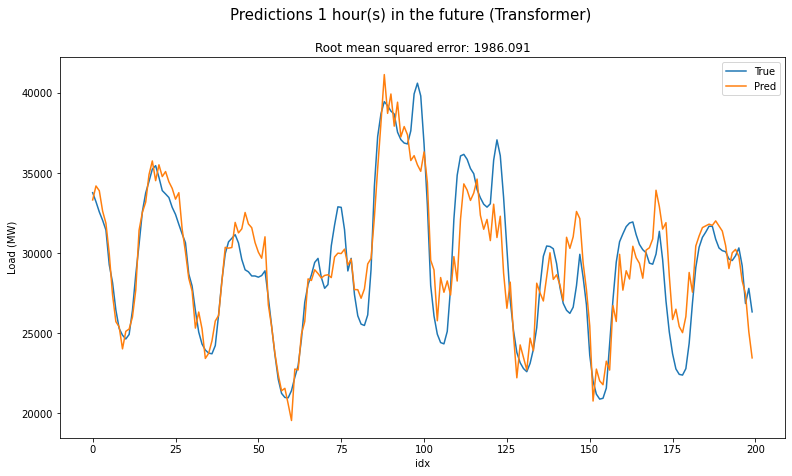

In [ ]:
WINDOW = 200
START = 500

# plt.plot(test_dataset.unscale(test_dataset.y[START:START+WINDOW, 0]), label="True")
# plt.plot(test_dataset.unscale(pred[START:START+WINDOW, 0]), label="Pred")
# plt.title("Predictions one hour in the future", fontsize=15)
# plt.xlabel("Hour", fontsize=14)
# plt.ylabel("Load", fontsize=14)
# plt.legend()

tra_true = y_test

plot_predictions(tra_true[500:700], tra_pred[500:700], 0, "Transformer")

Similar to nearly everything else about the model, the predictions are also very unstable :/ A good run can achieve RMSE around 1200.

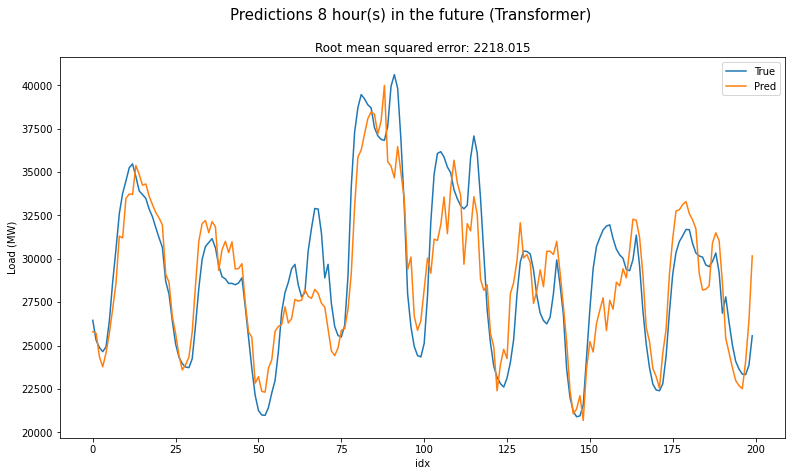

In [ ]:
plot_predictions(tra_true[500:700], tra_pred[500:700], 7, "Transformer")

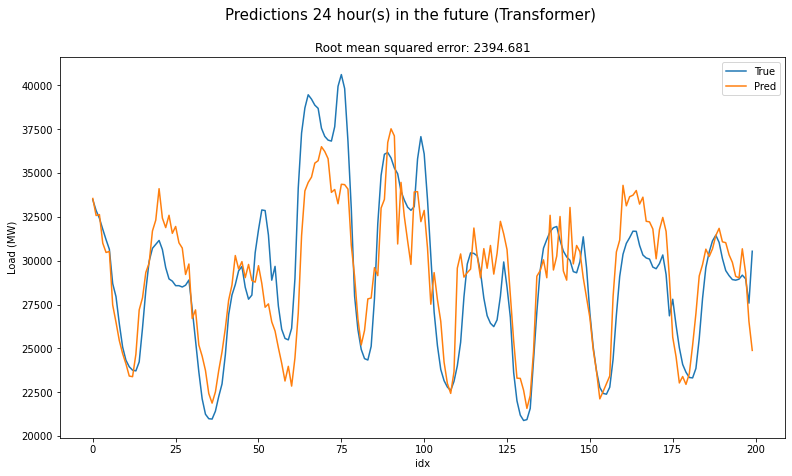

In [ ]:
plot_predictions(tra_true[500:700], tra_pred[500:700], 23, "Transformer")

In [ ]:
foo = foo.detach().cpu().numpy().mean(axis=(0,1))
bar = bar.detach().cpu().numpy().mean(axis=(0,1))

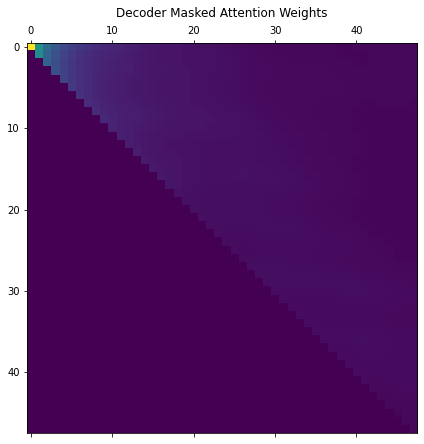

In [ ]:
plt.matshow(foo)
plt.title("Decoder Masked Attention Weights")
plt.show()

The above plot shows the (averaged across layers) weights from the masked attention units. Similar results were obtained for all of our experiments: the visualized matrix does not appear to show anything interesting. There may be a bug in our implementation, or perhaps it is just a matter of getting the model to converge. Unfortunately, developing the model was so timeconsuming that we were unable to resolve whatever is causing this. The expected result is a matrix which shows which values of the preceding sequence the model attends to.

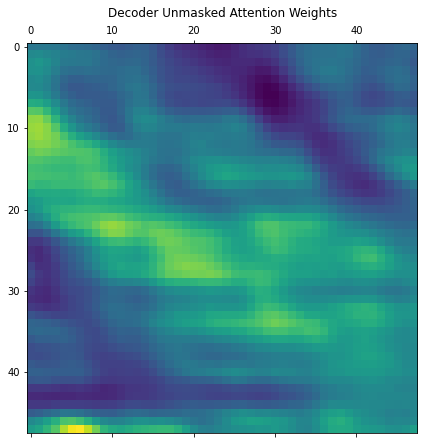

In [ ]:
plt.matshow(bar)
plt.title("Decoder Unmasked Attention Weights")
plt.show()

These results are (usually) more interesting, but can vary greatly because of how unstable the model is. In some cases we were able to obtain a matrix resembling the correlation matrix shown in the EDA section: it displayed greater values for time periods 24 hours away.

Ultimately, we cannot interpret the model unless it is properly optimized.

# Summary and Recommendations

In [ ]:
from sklearn.metrics import mean_squared_error


model_predictions = {
    "Lookback": look_pred,
    "Linear Regression": lin_pred, 
    "Neural Network": nn_pred,
    "Gaussian Process": gp_preds[2], 
    "Seq2SeqRNN": rnn_pred}

In [ ]:
def period_rmse(true, pred, time):
  rmse = mean_squared_error(true[:, time], pred[:, time], squared=False)
  return rmse

rmse_dict = {}
for i in (0, 7, 23):
  for name, pred in model_predictions.items():
    if name not in rmse_dict:
      rmse_dict[name] = [round(period_rmse(y_test, (pred * std)+mean, i), 3)]
    else:
      rmse_dict[name].append(round(period_rmse(y_test, (pred * std)+mean, i), 3))
tra_pred_scaled = (tra_pred * std) + mean 
rmse_dict['Transformer'] = [np.sqrt(mean_squared_error(tra_true[:tra_pred.shape[0], i], tra_pred_scaled[:, i])) for i in (0, 7, 23)]

We summarize the results of our models in the table below:

In [ ]:
summary = pd.DataFrame.from_dict(rmse_dict, orient='index')
summary.columns = ['RMSE 1h ahead', 'RMSE 8h ahead', 'RMSE 24h ahead']
summary

RMSE 1h ahead  RMSE 8h ahead  RMSE 24h ahead
Lookback             3598.883000    3598.665000     3596.956000
Linear Regression    1707.973000    2771.708000     2966.822000
Neural Network       1131.923000    2484.109000     2946.432000
Gaussian Process      793.014000    2520.224000     2965.601000
Seq2SeqRNN           1045.868000    2052.493000     2881.117000
Transformer          1557.191547    2000.777001     2599.574934

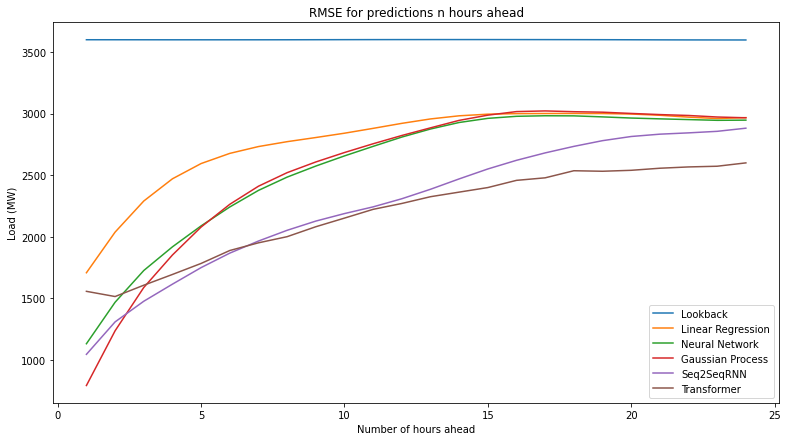

In [ ]:
xs = [i for i in range(1, 25)]
for name, preds in model_predictions.items():
  rmses = [mean_squared_error(y_test[:, i], (preds[:, i] * std)+mean, squared=False) for i in range(24)]
  plt.plot(xs, rmses, label=name)

rmses = [mean_squared_error(tra_true[:tra_pred.shape[0], i],
                            tra_pred_scaled[:, i], squared=False) for i in range(24)]
plt.plot(xs, rmses, label='Transformer')

plt.legend()
plt.title("RMSE for predictions n hours ahead")
plt.xlabel("Number of hours ahead")
plt.ylabel("Load (MW)")

plt.show()

The above plot shows how model RMSEs change as they predict values further away in the future. The Gaussian Process model shows the best results predicting 1h ahead, but quickly falls behind the RNN and transformer, which show noticeably better results over their counterparts. Surprisingly, depending on your luck with how unstable the transformer is, the transformer often shows the lowest RMSE out of all models for predictions 15+ hours ahead, but at the same time can fail to beat the linear regression model at predictions only 1 hour ahead. All of our models beat the baseline by a landslide.

If our primary goal is to obtain the most accurate predictions possible, we recommend that the RNN model is used as it offers one of the most lowest errors for all predictions regardless of how many hours ahead they are. Further testing should be performed to see if it can be optimized even better.

However, the RNN offers little interpretability of why it is making its predictions. For interpretability, both the linear regression and gaussian process models can be useful. Visualizing the linear regression model's weights allowed us to see which previous timepoints are most important for a given future prediction. Gaussian Processes offer the additional benefit of prediction intervals: surges in load are infrequent events, so most models will fail to predict them, but analyzing prediction intervals may give us a better understanding when there are greater chances of a surge.

The potential diamond in the rough is the transformer. We struggled a lot with optimizing it, and as such obtained satisfactory, but definitely not the best results. We recommend that more effort is put into developing this model, as it has the potential to offer both low error predictions and interpretability of why such predictions are made. Even in its unideal form it has shown to be capable of making better predictions for far-away time periods than its competitors.

One might consider using all the models in an ensemble to create better predictions. This comes with the advantage of ensemble uncertainty: we can use how much the models agree with one another to model our uncertainty on any one predictions. However, this "blackbox" approach lacks the intrepretability other models such as the Transformer and Linear Regression possess. As always in machine learning, there are trade offs to be had.

Still, we urge for the company to use the predictions from our models with great caution. All of the models are trained to do well on average across many datapoints, most of which display normal load behaviour. This means that potentially the most costly events, surges in load, are infrequent and our models are not optimized to capture them, meaning they are unlikely to accurately predict them. Furthermore, the prediction quality start to degrade the further into the future we go. We recommend the engineers to use our model to predict < 12 hours in advance to be safe.

Additional failsafes must be used alongside our models' predictions to be on the lookout for potential surges, otherwise catastrophic events may catch us on the blind side if solely our models are trusted. Our models should not be used as the singular source of truth; rather they should be a tool to inform experts.